# You're Toxic, I'm Slippin' Under: Toxic Comment Classification Challenge

#### STINTSY S13 Group 8
- VICENTE, Francheska Josefa
- VISTA, Sophia Danielle S.

## Introduction
In digital communities and forums on the internet, users often choose to remain anonymous as real names are not required when conversing with strangers online. With this anonymity comes the freedom to express one's thoughts without fear of being judged or recognized, yet this might also mean that users are free to say abusive sentiments with little to no repercussions. While most online forums and social media sites have various ways to moderate (e.g. moderators and staff that manually review posts and comments, a report button under messages, voting for comments and posts), these methods are not enough to combat the significant number of toxic comments made.

With this, ways to automate checking for toxicity in online text should be improved to foster a safe and respectful online environment.

## Toxic Comment Classification Challenge

The [`Toxic Comment Classification Challenge`](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview) is a Kaggle challenge by the [`Conversation AI team`](https://conversationai.github.io/), which is composed of researchers from both [`Jigsaw`](https://jigsaw.google.com/) and `Google`. This challenge invites participants to build a multi-headed model that can accurately detect the types of toxicity (i.e.,toxic, severe toxic, obscene, threat, insult, and identity hate) better than Perspective’s [current models](https://github.com/conversationai/unintended-ml-bias-analysis).

The dataset given contains a large number of Wikipedia comments which have been labeled by human raters for toxic behavior.

## Requirements and Imports
Before starting, the relevant libraries and files in building and training the model should be loaded into the notebook first.

### Import
Several libraries are required to perform a thorough analysis of the dataset. Each of these libraries will be imported and described below:

#### Basic Libraries 
Import `numpy` and `pandas`.
- `numpy` contains a large collection of mathematical functions
- `pandas` contains functions that are designed for data manipulation and data analysis

In [1]:
import numpy as np
import pandas as pd

#### Visualization Libraries 
- `matplotlib.pyplot` contains functions to create interactive plots
- `seaborn` is a library based on matplotlib that allows for data visualization
- `wordcloud` contains functions for generating wordclouds from text data

**NOTE:** `wordcloud` should be installed using `conda install -c conda-forge wordcloud`

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

#### Natural Language Processing Libraries 
- `re` is a module that allows the use of regular expressions
- `nltk` provides functions for processing text data
- `stopwords` is a corpus from NLTK, which includes a compiled list of stopwords
- `Counter` is from Python's `collections` module, which is helpful for tokenization
- `string` contains functions for string operations
- `TFidfVectorizer` converts the given text documents into a matrix, which has TF-IDF features 
- `CountVectorizer` converts the given text documents into a matrix, which has the counts of the tokens

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#### Machine Learning Libraries
The following code block can be used to install **scikit-multilearn** without restarting Jupyter Notebook. The `sys` module is used to access the *executable* function of the interpreter, which would run the installation of scikit-multilearn.

In [4]:
import sys
!{sys.executable} -m pip install scikit-multilearn

The following libraries are multi-label classification modules that would allow the usage of one model that can classify one instance as more than one class.
- `ClassifierChain` chains binary classifiers in a way that its predictions are dependent on the earlier classes
- `BinaryRelevance` uses binary classifiers to classify the classes independently
- `MultiOutputClassifier` fits one classifier per target class 
- `OneVsRestClassifier` fits one class against the other classes

In [5]:
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

The following classes are classifiers that implement different methods of classification.
- `RandomForestClassifier` is a class under the ensemble module that trains by fitting using a number of decision trees
- `GradientBoostingClassifier` is a class under the ensemble module that optimizes arbitrary differentiable loss functions
- `AdaBoostClassifier` is a class under the ensemble module that implements AdaBoost-SAMME
- `MultinomialNB` is a class under the Naive Bayes module that allows the classification of discrete features
- `LogisticRegression` is a class under the linear models module that implements regularized logistic regression

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

Meanwhile, the following classes are used for hyperparameter tuning.
- `ParameterGrid` is a class that allows the iteration over different combinations of parameter values 
- `GridSearchCV` is a cross-validation class that allows the exhaustive search over all possible combinations of hyperparameter values
- `RandomizedSearchCV` is a cross-validation class that allows a random search over some possible combinations of hyperparameter values
- `train_test_split` divides the dataset into two subsets

In [7]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

And lastly, these classes computes different scores about how well a model works.
- `log_loss` computes the Logistic loss given the true values and the predicted values
- `f1_score` computes the balanced F-score by comparing the actual classes and the predicted classes
- `accuracy_score` computes the accuracy by determining how many classes were correctly predicted

In [8]:
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [9]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category = ConvergenceWarning)

### Datasets and Files
There are four `.csv` files provided in the competition.
- `train.csv` is the training set, which contains comments and their classification (with the use of binary labels)
- `test.csv` is the test set, which contains comments and their corresponding IDs
- `sample_submission.csv` contains the correct submission format for the competition
- `test_labels.csv` was a file added after the competition closed

However, to do the task, we would only need to load two of these files: (1) `train.csv`, and (2) `test.csv`. These two `.csv` files will be loaded into the notebook using the [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

In [10]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

## Description of the Dataset

To see the the number of rows and columns for the `train` and `test` data, the [`shape`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html) property of the DataFrame is called.

In [11]:
train.shape

(159571, 8)

The `train` data has 159571 rows (instances) and eight (8) columns (features). An instance in our dataset represents a text and its categories. 

Next, the [`head`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) function is called to check the first few rows of the dataset. This will let us quickly check the features of the dataset.

In [12]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


As seen by the function's output, the eight columns are: `id`, `comment_text`, `toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`. 

The first column `id` is an object that contains a unique identifier for the row. This is followed by the `comment_text` column, which holds the text that we need to categorize into the different toxic categories. The next six (6) columns—`toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`—are integer columns, with a value of either 0 or 1, which represents `True` or `False`, respectively. These six columns represent the different categories. If the value for a specific column is 1, it means that the `comment_text` can be classified as this category.

It is important to note, however, that each `comment_text` can be classified under more than one toxic category (e.g. a comment can fall under both `toxic` and `severe_toxic` as denoted by the multiple values of 1 per row).

In [13]:
test.shape

(153164, 2)

On the other hand, the `test` dataset has 153164 rows and two (2) columns.

In [14]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \r\n\r\n The title is fine as i...
2,00013b17ad220c46,""" \r\n\r\n == Sources == \r\n\r\n * Zawe Ashto..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Each instance represents a comment that we have to compute for its probaility for the different categories mentioned. Like the `train` data, the first column is the `id`, which is a unique identifier. After this is the `comment_text`, which holds the text that our model needs as input. 

## Exploratory Data Analysis (EDA)
In order to determine which model would fit our dataset, we would need to explore the given data. 

**Four exploratory data analysis questions have been identified and formulated:**
1. Which words occur most frequently in the `train` data?
2. Based on the `train` data, how correlated are the given categories?
3. What is the range of `comment_text` character counts?
4. In the training data, how many instances does each type of toxic comment have?

To answer these questions, we used numerical summaries. Additionally, we used visualization techiniques in order to present and illustrate possible relationships in the data.

### Which words occur most frequently in the `train` data?

As a preliminary step in answering this question, all of the comments should be processed using tokenization, which is the process of separating pieces of text into words. 

For this, NLTK's [`RegexpTokenizer`](https://www.nltk.org/api/nltk.tokenize.regexp.html) is used to tokenize the text using RegEx. More specifically, the RegEx used is `\w+`, which retrieves all words (i.e. words with alphanumeric & underscore characters) from the text. Moreover, stopwords based on NLTK's Stopword corpus and single letters were filtered out of the tokens for a more accurate count of relevant words. 

It should be noted that tokenization was done for each toxic classification and for all comments as a whole, to contrast the differences of the frequently seen words in each category.

In [15]:
nltk.download('stopwords')

words = []
obscene = []
insult = [] 
toxic = []
severe_toxic = [] 
identity_hate = [] 
threat = []
tokenizer = nltk.RegexpTokenizer(r'\w+')
for index, x in train.iterrows():
    text = x ['comment_text']
    words += tokenizer.tokenize(text.lower())
    
    if x ['obscene'] == 1:
        obscene += tokenizer.tokenize(text.lower())
    if x ['insult'] == 1:
        insult += tokenizer.tokenize(text.lower())
    if x ['toxic'] == 1:
        toxic += tokenizer.tokenize(text.lower())
    if x ['severe_toxic'] == 1:
        severe_toxic += tokenizer.tokenize(text.lower())
    if x ['identity_hate'] == 1:
        identity_hate += tokenizer.tokenize(text.lower())
    if x ['threat'] == 1:
        threat += tokenizer.tokenize(text.lower())
        
all_words = Counter(words)
all_obscene = Counter(obscene)
all_insult = Counter(insult)
all_toxic = Counter(toxic)
all_severe_toxic = Counter(severe_toxic)
all_identity_hate = Counter(identity_hate)
all_threat = Counter(threat)

for stopword in stopwords.words("english"): 
    all_words.pop(stopword, None)
    all_obscene.pop(stopword, None)
    all_insult.pop(stopword, None)
    all_toxic.pop(stopword, None)
    all_severe_toxic.pop(stopword, None)
    all_identity_hate.pop(stopword, None)
    all_threat.pop(stopword, None)

for alpha_char in list(string.ascii_lowercase + string.ascii_uppercase):
    all_words.pop(alpha_char, None)
    all_obscene.pop(alpha_char, None)
    all_insult.pop(alpha_char, None)
    all_toxic.pop(alpha_char, None)
    all_severe_toxic.pop(alpha_char, None)
    all_identity_hate.pop(alpha_char, None)
    all_threat.pop(alpha_char, None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


To count the tokenized characters, Python's `Counter()` object was used to automatically count the number of tokens in the list of words retrieved above. The output for all the comments, arranged by total count in descending order, is as follows:

In [16]:
print('\n{}{}'.format('Token (All Comments)'.ljust(30), 'Count'))
for value, count in all_words.most_common(20):
    print('{}{}'.format(value.ljust(30), count))


Token (All Comments)          Count
article                       57661
wikipedia                     48427
page                          46460
talk                          37094
please                        29794
would                         29323
one                           29179
like                          28008
see                           21603
also                          20641
think                         20084
know                          19144
people                        18468
edit                          18288
articles                      16712
use                           16594
time                          15885
may                           15611
user                          14101
thanks                        13904


Next, the tokens for each toxic category will be shown below, arranged by total count in descending order.

In [17]:
print('\n{}{}'.format('Token (Insult)'.ljust(30), 'Count'))
for value, count in all_insult.most_common(10):
    print('{}{}'.format(value.ljust(30), count))

print('\n{}{}'.format('Token (Obscene)'.ljust(30), 'Count'))
for value, count in all_obscene.most_common(10):
    print('{}{}'.format(value.ljust(30), count))
    
print('\n{}{}'.format('Token (Toxic)'.ljust(30), 'Count'))
for value, count in all_toxic.most_common(10):
    print('{}{}'.format(value.ljust(30), count))
    
print('\n{}{}'.format('Token (Severe Toxic)'.ljust(30), 'Count'))
for value, count in all_severe_toxic.most_common(10):
    print('{}{}'.format(value.ljust(30), count))
    
print('\n{}{}'.format('Token (Identity Hate)'.ljust(30), 'Count'))
for value, count in all_identity_hate.most_common(10):
    print('{}{}'.format(value.ljust(30), count))
    
print('\n{}{}'.format('Token (Threat)'.ljust(30), 'Count'))
for value, count in all_threat.most_common(10):
    print('{}{}'.format(value.ljust(30), count))


Token (Insult)                Count
fuck                          7925
fucking                       2799
suck                          2792
nigger                        2781
go                            2235
ass                           2211
fat                           1926
faggot                        1867
bitch                         1733
shit                          1689

Token (Obscene)               Count
fuck                          9860
shit                          3212
fucking                       3192
suck                          3021
ass                           2846
nigger                        2727
go                            2147
wikipedia                     1905
bitch                         1795
like                          1541

Token (Toxic)                 Count
fuck                          9934
wikipedia                     3678
shit                          3622
like                          3512
nigger                        3300
fucking       

For a better visual representation of the frequency of these words, these words may be displayed in a wordcloud. Wordclouds are apt for this task as they give prominence to words based on their frequency.

A [`WordCloud()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) object is generated below, using the tokens from all comments.

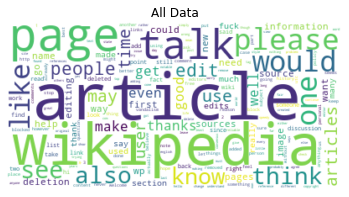

In [18]:
wordcloud = WordCloud(min_word_length = 3, background_color='white')
wordcloud.generate_from_frequencies(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('All Data')
plt.axis('off')
plt.show()

Next, several [`WordCloud()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) objects are generated using the tokens from each toxic category as follows:

#### Figure 1. Wordcloud of the Word Frequency of All of the Data

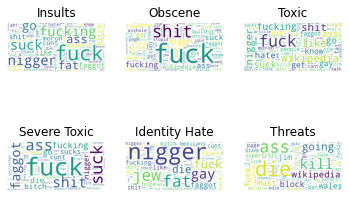

In [19]:
fig = plt.figure()

ax2 = fig.add_subplot(231)
wordcloud1 = WordCloud(min_word_length = 3, background_color='white')
wordcloud1.generate_from_frequencies(all_insult)
plt.imshow(wordcloud1)
plt.title('Insults')
plt.axis('off')

ax3 = fig.add_subplot(232)
wordcloud2 = WordCloud(min_word_length = 3, background_color='white')
wordcloud2.generate_from_frequencies(all_obscene)
plt.imshow(wordcloud2)
plt.title('Obscene')
plt.axis('off')

ax4 = fig.add_subplot(233)
wordcloud3 = WordCloud(min_word_length = 3, background_color='white')
wordcloud3.generate_from_frequencies(all_toxic)
plt.imshow(wordcloud3)
plt.title('Toxic')
plt.axis('off')

ax5 = fig.add_subplot(234)
wordcloud4 = WordCloud(min_word_length = 3, background_color='white')
wordcloud4.generate_from_frequencies(all_severe_toxic)
plt.imshow(wordcloud4)
plt.title('Severe Toxic')
plt.axis('off')

ax6 = fig.add_subplot(235)
wordcloud5 = WordCloud(min_word_length = 3, background_color='white')
wordcloud5.generate_from_frequencies(all_identity_hate)
plt.imshow(wordcloud5)
plt.title('Identity Hate')
plt.axis('off')

ax7 = fig.add_subplot(236)
wordcloud6 = WordCloud(min_word_length = 3, background_color='white')
wordcloud6.generate_from_frequencies(all_threat)
plt.imshow(wordcloud6)
plt.title('Threats')
plt.axis('off')

plt.show()

#### Figure 2. Wordcloud of the Word Frequency of Each of the Categories

From the list of frequent words outputted earlier and the wordclouds generated above (Figure 1 and 2), there are several things to note.

As expected of comments retrieved from Wikipedia's talk page edits, many of the words relate to Wikipedia itself (`article`, `articles`, `wikipedia`, `talk`, `page`, `edit`) and some words involve collaboration and communication between users for edits (`user`, `would`, `like`, `think`, `know`). Words such as `please` and `thanks` can be seen, indicating that many comments are civil and respectful.

However, most of the frequently appearing words coming from comments that fall under the various toxic categories are considered profane. Interestingly enough, specific types of words appear more frequently in some categories compared to others. For example, the category `identity_hate` has a higher frequency of various slurs, `threat` contains words relating to physical harm (e.g. `kill`, `die`), and `obscene` contains indecent words related to sexual acts or parts. Furthermore, the word `fuck` consistently appears as part of the ten most frequently seen words for all categories, even appearing as the most frequent word for `insult`, `obscene`, `toxic`, and `severe_toxic`.

### Based on the `train` data, how correlated are the given categories?
Since this challenge mainly focuses on determining the probability of a comment belonging to a specific category, we want to explore the correlations among the different categories. The correlation of each of the categories is computed using Pandas' [`corr`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) function. 

It should be noted that since there are only two values—0 and 1—possible for each of the categories, we would not have to worry for outliers.

In [20]:
correlation = train.corr()
correlation

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


Since it is hard to determine the correlation of the categories using just numbers, we can visualize these numbers using a [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

<AxesSubplot:>

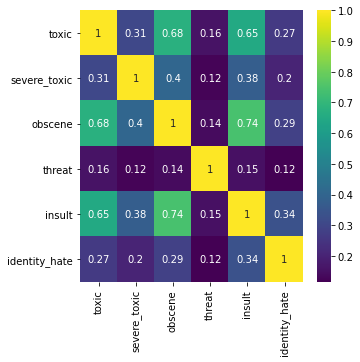

In [21]:
plt.figure (figsize = (5, 5))
sns.heatmap (data = correlation, xticklabels = correlation.columns.values, yticklabels = correlation.columns.values, cmap = 'viridis', annot=True)

#### Figure 3. Correlation Heatmap of the categories
From Figure 3, we can see that there is a low correlation between `threat` and all of the other categories. Additionally, `insult` and `obscene` has the highest correlation among the categories with a 0.74 or 74% correlation.

### What is the range of `comment_text` character counts?

Determining the range of the length of the string `comment_text` could help us in determining on how long are the words, phrases or sentences our model needs to handle. The length of the longest string can be determined through the use of the [`len`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.len.html) and [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) functions.

In [22]:
train['comment_text'].str.len().describe()

count    159571.000000
mean        396.593961
std         594.387869
min           6.000000
25%          97.000000
50%         207.000000
75%         438.000000
max        5000.000000
Name: comment_text, dtype: float64

From this, we can see that there is at least one string in the `comment_text` column with a length of 5000. This is far from the mean length, which is only 396.

To effectively analyze the length of the comments, we can sort our data frame (i.e., using the [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) function) based on the length of the `comment_text` column, from the longest to the shortest.

In [23]:
arranged_index  = train['comment_text'].str.len().sort_values(ascending = False).index
arranged_length = train.reindex (arranged_index)

length = train['comment_text'].str.len().sort_values(ascending = False)
arranged_length ['string_length'] = length
arranged_length

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,string_length
131729,c0e076f0011acaa6,"""FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C ...",1,1,1,0,1,0,5000
133254,c8f01ac90c4adc27,FUCK YOU ALL!! FUCK YOU ALL!! FUCK YOU ALL!!...,1,1,1,0,1,0,5000
4174,0b2055f13934a41e,ii CAN STILL POST WITH THIS COMPUTER...I SAID ...,1,0,1,0,1,0,5000
56834,97e695cfd71944ed,i CAN STILL POST WITH THIS COMPUTER...I SAID B...,1,1,1,0,1,0,5000
156437,ce2d7821188dd30f,HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGO...,1,1,1,0,1,1,5000
...,...,...,...,...,...,...,...,...,...
118850,7b3d18857df782cf,FUCK YOU,1,1,1,0,1,0,8
121074,87c06f935f2c6559,you suck,1,0,1,0,1,0,8
109985,4c5cde3ab1a618c9,{{unbloc,0,0,0,0,0,0,8
52442,8c4c53001134f290,"14:53,",0,0,0,0,0,0,6


As we can see, there are several rows with a string length of 5000. From the five comments shown, we can see that it is mostly made up of uppercase characters and copypasted words.

Additionally, we can see that there are **42 rows** that has a string length of 5000 for the `comment_text` column. 

In [24]:
len(arranged_length [arranged_length ['string_length'] == 5000])

42

Through the use of a [`box`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.box.html) plot, we can see how dispersed our data is.

<AxesSubplot:>

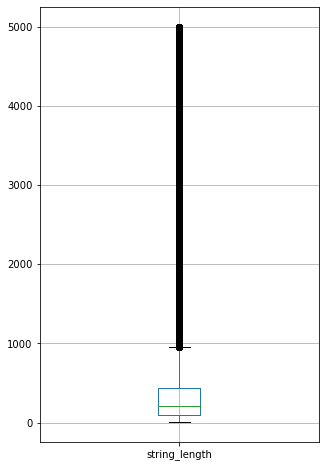

In [25]:
arranged_length ['string_length'].plot.box(grid='True', figsize=(5, 8))

#### Figure 4. Box Plot of the Length of `comment_text`
Using Figure 4, we can see that there are outliers in the length of the `comment_text` as there are comments with lengths that are higher than the upper whisker. Additionally, this boxplot visually complements what we have learned in the output of the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function: 50% of the length of the `comment_text` column can be found within the range of 97 and 438, with an Interquartile range (IQR) of 341.

### In the training data, how many instances does each type of toxic comment have?
Last, we can get the number of instances that are classified as a specific type of toxic comment. This can help us determine if the classes are balanced or imbalanced in terms of instances.

For this, we will first get the classes of our train data.

In [47]:
classes = train.columns[2: ]
classes

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

Afterwards, per class, we would be counting the number of rows with **1** as a value. This is because **1** means that the `comment_text` of that row is classified as this class. 

In [27]:
data = []
for class_ in classes:
    data.append([class_, sum(train [class_] == 1)])
    
data

[['toxic', 15294],
 ['severe_toxic', 1595],
 ['obscene', 8449],
 ['threat', 478],
 ['insult', 7877],
 ['identity_hate', 1405]]

The resulting array would be converted into a dataframe. Then, it would be sorted in descending order so that the class with the highest count could be determined smoothly.

In [28]:
data = pd.DataFrame(data, columns=['Class', 'Count'])
data = data.sort_values(by = ['Count'], ascending = False)
data

,Class,Count
0,toxic,15294
2,obscene,8449
4,insult,7877
1,severe_toxic,1595
5,identity_hate,1405
3,threat,478


As the count per class is stored in a dataframe, we could easily visualize this using a [`bar`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html) graph.

<AxesSubplot:xlabel='Class'>

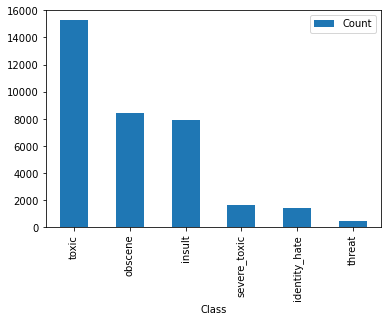

In [29]:
data.plot.bar(x = 'Class', y = 'Count')

#### Figure 5. Bar Graph of the Count of Instances per Class
Using Figure 5, **toxic** was determined as the class with the highest number of instances in the train set, with 15294 instances. This is followed by **obscene** (8449), **insult** (7877), **severe_toxic** (1595),  **identity_hate** (1405), and then, **threat** (478).

From this, we determined that the instances per class is not balanced, which is why we have to make sure that the models would weigh the class weights based on this fact.

## Data Pre-Processing and Cleaning
For the data cleaning, we would check if the test and train data: (1) has the correct data type, (2) has **NaN** values, and (3) has duplicate rows. 

Once we have checked and fixed these errors, we would employ some common NLP text preprocessing techniques. We would first convert all alphabetical characters into lowercase, expand contractions, and remove all non-word characters. These techniques will help remove noise and enable the various vectorizers (e.g., **TF-IDF** (Term Frequency–Inverse Document Frequency) vectorizer) to effectively vectorize the text data. 

### Data Types of the Variables
For both `train` and `test` data, we are expecting that the `id` and the `comment_text` columns are object types as these columns are made up of alphanumeric characters. 

For the succeeding columns of the `train` data, these columns should be the integers 0 and 1, as these serve as boolean flags  that indicate the classification of the `comment_text`.

In [30]:
train.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [31]:
test.dtypes

id              object
comment_text    object
dtype: object

Moreover, we should also verify if all values under the boolean values are indeed 0s and 1s. This can be done by using the `unique` function to see all unique values; this should be an array containing only 0 and 1.

In [48]:
for class_ in classes:
    print(class_, train[class_].unique())

toxic [0 1]
severe_toxic [0 1]
obscene [0 1]
threat [0 1]
insult [0 1]
identity_hate [0 1]


As the data types of the column are what we expected, we do not need to perform any cleaning here.

### Checking for `NaN`
Additionally, we also need to check if there are rows with **NaN** value for any of the columns. This is because having a **NaN** value for any of the columns are not allowed as it might affect the learning or prediction of our model.

The combination of the [`isna`](https://pandas.pydata.org/docs/reference/api/pandas.isna.html) and [`sum`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html) functions would allow us to see how many rows have **NaN** values for each of the columns.

In [32]:
train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [33]:
test.isna().sum()

id              0
comment_text    0
dtype: int64

With this, we are sure that all of the rows have values for each of the columns.

### Checking for Duplicate Rows
Then, we also have to check if there are rows that are duplicated. In the case that there are duplicated rows, they should be dropped as it might bias the models towards these duplicated rows.

We can check for duplicates using the [`duplicated`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html) function.

In [34]:
train [train.duplicated()]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [35]:
test [test.duplicated()]

,id,comment_text


Since we are now certain that there are no duplicates, we can now proceed with cleaning the content of the `comment_text` column.

### Expanding the Contractions
In Natural Language Processing, the `contractions` is one of the libraries that is used to expand contractions. However, even though this library worked for the train data, an *IndexError* was raised in the testing data. Upon researching, this stemmed from the fact that the `fix` function of this library can only handle UTF-8 characters. Due to this, a function that can handle this expansion was created.

In [36]:
def expand_contractions (comment_text):
    comment_text = re.sub(r"won\'t", "will not", comment_text)
    comment_text = re.sub(r"can\'t", "can not", comment_text)

    comment_text = re.sub(r"n\'t", " not", comment_text)
    comment_text = re.sub(r"\'re", " are", comment_text)
    comment_text = re.sub(r"what's", " is", comment_text)
    comment_text = re.sub(r"\'s", " ", comment_text) # to remove 's in possessive noun's
    comment_text = re.sub(r"\'d", " would", comment_text)
    comment_text = re.sub(r"\'ll", " will", comment_text)
    comment_text = re.sub(r"\'t", " not", comment_text)
    comment_text = re.sub(r"\'ve", " have", comment_text)
    comment_text = re.sub(r"\'m", " am", comment_text)
    return comment_text.strip ()

The `comment_text` column of both the `train` and `test` data would be mapped to the words returned by this function. Take note that the value of the `comment_text` column would be converted into lowercase in order to lessen the vocabulary, which in turn would lower the dimension of the TF-IDF vector.

In [37]:
train ['comment_text'] = train ['comment_text'].map (lambda text : expand_contractions (text.lower ()))
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation\r\nwhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww! he matches this background colour i am ...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, i am really not trying to edit war. i...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nmore\r\ni can not make any real suggestio...",0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::and for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,you should be ashamed of yourself \r\n\r\nthat...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"spitzer \r\n\r\numm, theres no actual article ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0,0,0,0,0,0


In [38]:
test ['comment_text'] = test ['comment_text'].map (lambda text : expand_contractions (text.lower ()))
test

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...
1,0000247867823ef7,== from rfc == \r\n\r\n the title is fine as i...
2,00013b17ad220c46,""" \r\n\r\n == sources == \r\n\r\n * zawe ashto..."
3,00017563c3f7919a,":if you have a look back at the source, the in..."
4,00017695ad8997eb,i do not anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \r\n i totally agree, this stuff is nothing ..."
153160,fffd7a9a6eb32c16,== throw from out field to home plate. == \r\n...
153161,fffda9e8d6fafa9e,""" \r\n\r\n == okinotorishima categories == \r\..."
153162,fffe8f1340a79fc2,""" \r\n\r\n == """"one of the founding nations of..."


However, from the current `test` and `train` data, we can see that if we make use of TF-IDF on terms above, we would still see problems with whitespaces (e.g., new line characters, tab characters) and non-alphanumeric characters (e.g., equals sign, ellipses, repeated punctuation marks).

### Removing Non-word Characters
To remove the problem regarding white spaces and non-alphanumeric characters, we would be utilizing regular expressions to easily remove these two types of characters. To do this easily, we defined a function that would return a string that only has alphanumeric characters. 

In [39]:
def remove_other_chars (comment_text):
    comment_text = re.sub ('\W', ' ', comment_text)
    comment_text = re.sub ('\s+', ' ', comment_text)
    comment_text = re.sub(r'\b\d+\b', '', comment_text)
    return comment_text.strip ()

Next, we would apply this function to the `comment_text` column of both the `train` and `test` data.

In [40]:
train ['comment_text'] = train ['comment_text'].map (lambda text : remove_other_chars (text.lower ()))
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can not make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when your vi...,0,0,0,0,0,0
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ho...,0,0,0,0,0,0
159568,ffee36eab5c267c9,spitzer umm theres no actual article for prost...,0,0,0,0,0,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0,0,0,0,0,0


In [41]:
test ['comment_text'] = test ['comment_text'].map (lambda text : remove_other_chars (text.lower ()))
test

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...
1,0000247867823ef7,from rfc the title is fine as it is imo
2,00013b17ad220c46,sources zawe ashton on lapland
3,00017563c3f7919a,if you have a look back at the source the info...
4,00017695ad8997eb,i do not anonymously edit articles at all
...,...,...
153159,fffcd0960ee309b5,i totally agree this stuff is nothing but too ...
153160,fffd7a9a6eb32c16,throw from out field to home plate does it get...
153161,fffda9e8d6fafa9e,okinotorishima categories i see your changes a...
153162,fffe8f1340a79fc2,one of the founding nations of the eu germany ...


As we can see, the repetitive punctuations and the white space characters in the `comment_text` for both `test` and `train` data are now gone. We can say that our data is now clean. 

Although, we can see that there are still misspellings, this would not be cleaned. 

## Feature Engineering
As we are dealing with text data, we would have to transform the `comment_text` column into a feature that our models can use. 

In Natural Language Processing, one of the most utilized methods in feature engineering for classifying text data is the use of vectorization. But, before we do that, let us extract the feature column for both the train and test data.

In [42]:
X_train = train ['comment_text']
X_test = test ['comment_text']

To ensure that the best model was found, the accuracy would be compared using the two well-known vectors in Natural Language Processing: (1) TF-IDF (Term Frequency - Inverse Document Frequency) Vectorization, and (2) Count Vectorization. Thus, two vectorizers would be declared.

In [43]:
tfidf_vectorizer = TfidfVectorizer()

In [44]:
count_vectorizer = CountVectorizer()

Furthermore, a copy of the vectorizer that only takes into account the top 5000 features is also created for each of the vectorizers.

In [45]:
tfidf_vectorizer_5000 = TfidfVectorizer(max_features = 5000)

In [46]:
count_vectorizer_5000 = CountVectorizer(max_features = 5000)

The idea behind the **TF-IDF Vector** is that it is able to represent how important a word is in a given document, and documents with similar important words would have similar vectors. Thus, if a documents have similar vectors, then we could classify the test document into the similar class as the train document. Meanwhile, the **Count Vector** shows the number of occurrences of a word in a given document.

Once the vectorizers are made, we can learn the vocabulary and fit the vectors from the training set. Additionally, we can get the learned document-term matrix using the `fit_transform` function.

In [47]:
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [48]:
count_train = count_vectorizer.fit_transform(X_train)

In [49]:
tfidf_train_5000 = tfidf_vectorizer_5000.fit_transform(X_train)

In [50]:
count_train_5000 = count_vectorizer_5000.fit_transform(X_train)

As we now have trained our vectors, we can now use these to get the corresponding document-term matrix of our test data.

In [51]:
tfidf_test = tfidf_vectorizer.transform(X_test)

In [52]:
count_test = count_vectorizer.transform(X_test)

In [53]:
tfidf_test_5000 = tfidf_vectorizer_5000.transform(X_test)

In [54]:
count_test_5000 = count_vectorizer_5000.transform(X_test)

## Model Training
As the task that was given in the challenge needs a multi-label classifier, we had three things to decided on: (1) the approach that would be used (i.e., an n-classifier approach or a 1-classifier approach), (2) the estimator that would be utilized, and (3) for the n-classifier, the meta-estimator that we would use.

As the score is important to the challenge, we decided to compare the score output of the n-classifiers and 1-classifier. Thus, we can move on with the next question: What estimator should we utilize?

### Initializing Variables
Before we start with the models, we would first declare the `y_train` values that we would be feeding our models.

In [55]:
y_train = train.loc [ : , 'toxic' : ]

### Declaring Helper Functions
As we would be training many models, it would be better to declare functions that would repeatedly use. This would abstract these repeated lines of code, which could help us focus on the more important things.

First, we will first create the dataframe that would hold the predicted values for the test set. Then, the `to_submission_csv` and the `to_submission_csv_multiclass` functions would save the values fo the dataframe into a CSV file.

In [56]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission ['id'] = test ['id']

In [57]:
def to_submission_csv(predictions, filename):
    for i in range (6):
        sample_submission[classes [i]] = predictions[:, i : i + 1]

    sample_submission.to_csv(f'results/' + filename + '.csv', index = False) 

In [58]:
def to_submission_csv_multiclass(predictions, filename):
    for i in range (6):
        temp = list(zip(*predictions[i]))
        sample_submission[classes [i]] = temp[1]

    sample_submission.to_csv(f'results/' + filename + '.csv', index = False)     

As the task requires us to give predictions for six classes, the `train_models` function would train multiple classifiers that will give predictions for a given class. The function would fit each classifier using the passed train set, compute for the training accuracies for each class, then predict the classes of the passed test set.

The function will return the trained models and the probability that the instance is categorized under a specific label. Take note that in predicting for the test data, `predict_proba` was used because the challenge uses ROC AUC as its scorer, and it aims to determine the probability of belonging to the label, and not the label itself.

In [59]:
def train_models(model, X_train, X_test):
    """Trains six models using a given train and test set.

    Parameters
    ----------
    model : estimator object
        the type of estimator to be trained 
    X_train : 
        the data used in fitting the model
    X_test : 
        the data to be predicted

    Returns
    -------
    models
        a list of fitted estimator objects
    test_predictions
        a list of prediction probabilities by the fitted model
    """
    
    test_predictions = np.zeros((len(test), len(classes)))                  # initialize empty list for predictions
    models = []                                                             # initialize empty list for models
    train_accuracy = []
    
    
    print('Fitting', str(model) + '...')
    
    for i in range(6):                                                      # loop for each of six classes
        
        model.fit(X_train, y_train[classes[i]])                             # fit the model
        
        train_predictions = model.predict(X_train)                          # predict using train data
        accuracy = accuracy_score(train_predictions, y_train[classes[i]])   # get training accuracy 
        print(classes[i] + ':', accuracy)
        
        test_predictions[:,i] = model.predict_proba(X_test)[:,1]            # predict using test data
        
        models += [model]
        train_accuracy += [accuracy]
    
    print('\nOverall training accuracy:', np.mean(train_accuracy))
    
    return models, test_predictions

Similarly, the `tune_and_train_models` function will train multiple classifiers with the addition of hyperparameter tuning to achieve a better training accuracy. Hyperparameter tuning will be done using a `GridSearchCV` for a more comprehensive search.

In [60]:
def tune_and_train_models(model, hyperparameters, X_train, X_test, scoring='accuracy', cv=2):
    """Tunes six models using a given train and test set.

    Parameters
    ----------
    model : estimator object
        the type of estimator to be trained 
    hyperparameters : estimator object
        the hyperparameters used for tuning the model  
    X_train : 
        the data used in fitting the model
    X_test : 
        the data to be predicted
    scoring : 
        the metric for deciding the best combination of parameters

    Returns
    -------
    models
        a list of fitted estimator objects
    test_predictions
        a list of prediction probabilities by the fitted model
    """
    
    test_predictions = np.zeros((len(test), len(classes)))                  # initialize empty list for predictions
    models = []                                                             # initialize empty list for models
    train_accuracy = []
    
    print('Tuning', str(model) + '...')
    
    for i in range(6):                                                              # loop for each of six classes
        model_cv = GridSearchCV(model, hyperparameters, 
                                cv=cv, scoring=scoring)
        model_cv.fit(X_train, y_train[classes[i]])
        
        train_predictions = model_cv.predict(X_train)                               # predict using train data
        accuracy = accuracy_score(train_predictions, y_train[classes[i]])           # get training accuracy 
        print(classes[i] + ':', accuracy, model_cv.best_params_)
        
        test_predictions[:,i] = model_cv.predict_proba(X_test)[:,1]                 # predict using test data
        
        models += [model_cv.best_estimator_]
        train_accuracy += [accuracy]
    
    print('\nOverall training', scoring + ':', np.mean(train_accuracy))
    
    return models, test_predictions

Multi-label classifiers would follow the pipeline of training the model, getting the training predictions, and predicting the classes of the test data. As such, the `_train_model` function will forgo the loop and proceed to train the model using the whole `y_train`.

In [61]:
def train_model(model, X_train, X_test, dense=False):
    """Trains a model using a given train and test set.

    Parameters
    ----------
    model : estimator object
        the type of estimator to be trained 
    X_train : 
        the data used in fitting the model
    X_test : 
        the data to be predicted
    dense : 
        a boolean value indicating if the predictions need to be converted to dense

    Returns
    -------
    model
        a fitted estimator object
    test_predictions
        a list of prediction probabilities by the fitted model
    """
    
    print('Fitting', str(model) + '...')
    
    model.fit(X_train, y_train)                                               # fit the model
    train_predictions = model.predict(X_train)                                # predict using train data
    
    if dense:                                           
        train_predictions = train_predictions.todense()                       # convert predictions to dense
        
    accuracy = accuracy_score(train_predictions, y_train)                     # get training accuracy 
    print(accuracy)                                                        
    
    test_predictions = model.predict_proba(X_test)                            # predict using test data
    
    return model, test_predictions

As with the previous functions, the `tune_and_train_model` function will tune a single multi-label classifier using a `GridSearchCV` to increase the training accuracy.

In [62]:
def tune_and_train_model(model, hyperparameters, X_train, X_test, scoring='accuracy', dense=False):
    """Tunes a model using a given train and test set.

    Parameters
    ----------
    model : estimator object
        the type of estimator to be trained 
    hyperparameters : estimator object
        the hyperparameters used for tuning the model  
    X_train : 
        the data used in fitting the model
    X_test : 
        the data to be predicted
    scoring : 
        the metric for deciding the best combination of parameters
    dense : 
        a boolean value indicating if the predictions need to be converted to dense

    Returns
    -------
    model
        a  fitted estimator object
    test_predictions
        a list of prediction probabilities by the fitted model
    """
    
    print('Tuning', str(model) + '...')

    model_cv = GridSearchCV(model, hyperparameters, 
                            cv=2, scoring=scoring)
    model_cv.fit(X_train, y_train)

    train_predictions = model_cv.predict(X_train)                                # predict using train data
    
    if dense:                                           
        train_predictions = train_predictions.todense()                          # convert predictions to dense
        
    accuracy = accuracy_score(train_predictions, y_train)                        # get training accuracy                                                   
    
    test_predictions = model_cv.predict_proba(X_test)                            # predict using test data
    
    return model_cv, test_predictions

### Deciding on the Estimator
For the estimator, we decided to compare the n-classifiers of Multinomial Naive Bayes and Logistic Regression, as these are the two estimators that are widely used for text classification. The one that yielded a higher score would be the one utilized in further experiements.

First, we will be declaring a MultinomialNB() object with default parameters, which will serve as the base classifier.

In [63]:
mn = MultinomialNB()

This model will first be trained using the count vectorized train data.

In [64]:
%%time
mn_models_count, predictions_mn_count = train_models(mn, count_train, count_test)
to_submission_csv(predictions_mn_count, 'submission_mn_count')

Fitting MultinomialNB()...
toxic: 0.9513696097661856
severe_toxic: 0.98641983819115
obscene: 0.9670867513520627
threat: 0.9955505699657206
insult: 0.9646301646289113
identity_hate: 0.9877233331871079

Overall training accuracy: 0.975463377848523
Wall time: 7.01 s


Then, the model will be trained with a TF-IDF vector as an input.

In [65]:
%%time
mn_models_tfidf, predictions_mn_tfidf = train_models(mn, tfidf_train, tfidf_test)
to_submission_csv(predictions_mn_tfidf, 'submission_mn_tfidf')

Fitting MultinomialNB()...
toxic: 0.9236828747078103
severe_toxic: 0.9899104473870566
obscene: 0.9538449968979326
threat: 0.996973134216117
insult: 0.9535629907689994
identity_hate: 0.9911074067343063

Overall training accuracy: 0.968180308452037
Wall time: 6.17 s


From the output of the Multinomial Naive Bayes, we can see that the one that used a TF-IDF vector is faster in executing and had a higher score than the Count vector.

Next, a Logistic Regression model will be created with default parameters, except for the `class_weight`, which will be equated to **balanced**. This is needed because of the imbalance in the class frequencies in the data.

In [66]:
lr = LogisticRegression(n_jobs=-1, class_weight='balanced')

Using the created model, we will be training a model with a Count vector as its input.

In [67]:
%%time
lr_models_count, predictions_lr_count = train_models(lr, count_train, count_test)
to_submission_csv(predictions_lr_count, 'submission_lr_count')

Fitting LogisticRegression(class_weight='balanced', n_jobs=-1)...
toxic: 0.9619542398054785
severe_toxic: 0.9745254463530341
obscene: 0.9747886520733717
threat: 0.9962712522952165
insult: 0.9625997205005922
identity_hate: 0.9764368212269147

Overall training accuracy: 0.9744293553757678
Wall time: 1min 55s


Like in the Multinomial Naive Bayes model, we will also be training a model that utilizes a TF-IDF as an input.

In [68]:
%%time
lr_models_tfidf, predictions_lr_tfidf = train_models(lr, tfidf_train, tfidf_test)
to_submission_csv(predictions_lr_tfidf, 'submission_lr_tfidf')

Fitting LogisticRegression(class_weight='balanced', n_jobs=-1)...
toxic: 0.9574296081368169
severe_toxic: 0.9794135525878762
obscene: 0.9807734488096208
threat: 0.9937519975434133
insult: 0.9681082402190875
identity_hate: 0.9810303877270933

Overall training accuracy: 0.976751205837318
Wall time: 1min 34s


The resulting files from these models were submitted to the challenge in Kaggle, which resulted in the following private and public score.

<table class="tg">
<thead>
  <tr>
    <th class="tg-1wig"></th>
    <th class="tg-1wig">private</th>
    <th class="tg-1wig">public</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-baqh">submission_mn_count</td>
    <td class="tg-baqh">0.84551</td>
    <td class="tg-baqh">0.85581</td>
  </tr>
  <tr>
    <td class="tg-baqh">submission_mn_tfidf</td>
    <td class="tg-baqh">0.82507</td>
    <td class="tg-baqh">0.83584</td>
  </tr>
  <tr>
    <td class="tg-baqh">submission_lr_count</td>
    <td class="tg-baqh">0.94598</td>
    <td class="tg-baqh">0.94576</td>
  </tr>
  <tr>
    <td class="tg-baqh">submission_lr_tfidf</td>
    <td class="tg-baqh">0.97558</td>
    <td class="tg-baqh">0.97621</td>
  </tr>
  <tr>
</tbody>
</table>

From this, we can see that the models that utilize Logistic Regression were higher than their counterpart in Multinomial Naive Bayes (i.e., the one that used the same input vector). Thus, we have decided to continue with using Logistic Regression as the estimator.

### Deciding on the Meta-Estimator
Next, as we already have our estimator, we can now continue with deciding the meta-estimator, which would be utilized for the 1-classifier. For multi-label classifiers, there is two main approaches: (1) Classifier Chain, and (2) Binary Relevance. ClassifierChain is the approach used if there are dependencies between the labels, while Binary Relevance is an intuitive approach for multi-label classification, which is fitting one classifier each for the labels (i.e., what we are doing in the n-classifiers). 

As we have seen in the EDA that the correlations between some of the labels are low, we have decided to continue with Binary Relevance. Thus, we will be creating a Binary Relevance object with a Logistic Regression model as its estimator.

Then, a model would be trained using a Count vector with 5000 features. The maximum features utilized by this model would avoid memory errors as this model has a higher memory need than other multi-label or multi-class classifiers.

Likewise, we would be training a model with a TF-IDF vector (with 5000 features) as its input.

### Finding a Substitute for Binary Relevance
Due to the high resource needs of Binary Relevance and its speed (i.e., training for nine hours on a device with an 8GB RAM and an Intel Core i7-1065G7 CPU), we tried to find a model that utilizes the same idea as Binary Relevance but faster. With this, we found `MultiOutputClassifier` and `OneVsRestClassifier`. Although `OneVsRestClassifier` is natively used as a multi-class classifier, it can also be used as a multi-label, wherein it would turn into comparing the probability of belonging into a label, rather than determining which label an instance belongs to. Thus, we would be creating models for each of these classifiers.

First, we would be creating a `MultiOutputClassifier` object with a `LogisticRegression` base estimator. 

In [69]:
mo_lr = MultiOutputClassifier(LogisticRegression(n_jobs=-1, class_weight='balanced'))

A copy of this model would be trained using a Count vector with no explicitly declared number of maximum number of features, as the `MultiOutputClassifier` can handle the total number of features created by a default Count vector.

In [70]:
%%time
mo_lr_model_count, predictions_mo_lr_count = train_model(mo_lr, count_train, count_test)
to_submission_csv_multiclass(predictions_mo_lr_count, 'submission_mo_lr_count')

Fitting MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   n_jobs=-1))...
0.8935896873492051
Wall time: 1min 43s


Afterwards, another copy of this model would be trained with a TF-IDF vector.

In [71]:
%%time
mo_lr_model_tfidf, predictions_mo_lr_tfidf = train_model(mo_lr, tfidf_train, tfidf_test)
to_submission_csv_multiclass(predictions_mo_lr_tfidf, 'submission_mo_lr_tfidf')

Fitting MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   n_jobs=-1))...
0.9042495190228801
Wall time: 1min 31s


On the other hand, we would also be creating a `OneVsRestClassifier` object with the same base estimator.

In [72]:
oc_lr = OneVsRestClassifier(LogisticRegression(class_weight='balanced'))

Like for the previous models, we would first be using a Count vector to train this model.

In [73]:
%%time
oc_lr_model_count, predictions_oc_lr_count = train_model(oc_lr, count_train, count_test)
to_submission_csv(predictions_oc_lr_count, 'submission_oc_lr_count')

Fitting OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced'))...
0.8949370499652193
Wall time: 1min 53s


Meanwhile, a copy of this model would be trained using a TF-IDF vector.

In [74]:
%%time
oc_lr_model_tfidf, predictions_oc_lr_tfidf = train_model(oc_lr, tfidf_train, tfidf_test)
to_submission_csv(predictions_oc_lr_tfidf, 'submission_oc_lr_tfidf')

Fitting OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced'))...
0.9042557858257453
Wall time: 1min 39s


<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-1wig{font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-baqh{text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-1wig"></th>
    <th class="tg-1wig">private</th>
    <th class="tg-1wig">public</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-baqh">submission_mo_lr_count</td>
    <td class="tg-baqh">0.94598</td>
    <td class="tg-baqh">0.94576</td>
  </tr>
  <tr>
    <td class="tg-baqh">submission_mo_lr_tfidf</td>
    <td class="tg-baqh">0.97558</td>
    <td class="tg-baqh">0.97621</td>
  </tr>
  <tr>
    <td class="tg-baqh">submission_oc_lr_count</td>
    <td class="tg-baqh">0.94598</td>
    <td class="tg-baqh">0.94576</td>
  </tr>
  <tr>
    <td class="tg-baqh">submission_oc_lr_tfidf</td>
    <td class="tg-baqh">0.97558</td>
    <td class="tg-baqh">0.97621</td>
  </tr>
  <tr>
</tbody>
</table>

Using the ROC AUC scores given by the competition, we can see that the scores of the models are the same. Even the time of execution of both models only has minimal difference. But, from this, we can see that the TF-IDF models scored higher compared to those models who used Count vectors.

### Hyperparameter Tuning
As we already know that TF-IDF models have higher ROC AUC scores, we can try to tune the TF-IDF model of both `MultiOutputClassifier` and `OneVsRestClassifier` as the **representative of our 1-Classifier**. The result of this would help us decide which is a better model of the two.

To start with hyperparameter tuning, we would declare the different hyperparameters that we would like to tune and the choices for their values. Values above and below the default values were added to determine how the increase or decrease of the values would affect the model's accuracy on the training data, and more importantly, on the test data.

**Note: The following cells (under the Hyperparameter Tuning header) is expected to run for around one (1) hour (i.e., tested on a device with 8GB RAM).**

In [75]:
parameters_lr_mo = [{
    'estimator__C': [0.01, 0.1, 1, 10],           
    'estimator__max_iter': [50, 100, 300, 600, 900] 
}]

In [76]:
parameters_lr = [{
    'C' : [0.01, 0.1, 1, 10],
    'max_iter' : [50, 100, 300, 600, 900] 
}]

First, we would declare a `MultiOutputClassifier` estimator object, which would be used by the `GridSearchCV`.

In [77]:
mo_lr = MultiOutputClassifier(LogisticRegression(n_jobs=-1, class_weight='balanced'))

We would be tuning a model that utlized this base estimator using the `GridSearchCV` class. Additionally, predictions on the test set would be made, and these predictions would be saved into a CSV file.

In [78]:
%%time
mo_lr_model_tfidf_tuned, predictions_mo_lr_tfidf_tuned = tune_and_train_model(mo_lr, 
                                                                              parameters_lr_mo, 
                                                                              tfidf_train, 
                                                                              tfidf_test)
to_submission_csv_multiclass(predictions_mo_lr_tfidf_tuned, 'submission_mo_lr_tfidf_tuning')

Tuning MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   n_jobs=-1))...
Wall time: 35min 45s


Then, we would be creating a `OneVsRestClassifier` as a base estimator that the `GridSearchCV` would try to tune.

In [79]:
oc_lr = OneVsRestClassifier(LogisticRegression(class_weight='balanced'))

As we already have a base estimator, we could pass this to `GridSearchCV`, and then create predictions on the test set, which would be put into a CSV file.

In [80]:
%%time
oc_lr_model_tfidf_tuned, predictions_oc_lr_tfidf_tuned = tune_and_train_model(oc_lr, 
                                                                              parameters_lr_mo, 
                                                                              tfidf_train, 
                                                                              tfidf_test)
to_submission_csv(predictions_oc_lr_tfidf_tuned, 'submission_oc_lr_tfidf_tuning')

Tuning OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced'))...
Wall time: 26min 33s


Let us see the different hyperparameter combinations and their accuracy scores.

In [81]:
def print_hyperparamter_score (name, model):
    print(name)
    for i in range (len(model.cv_results_['params'])):
        params = model.cv_results_['params'][i]
        score = model.cv_results_['mean_test_score'][i]
        print('Hyperparameters: ', params, ' Score: ', score)
    print('\n')

In [82]:
print_hyperparamter_score('MultiOutputClassifier (Logistic Regression)', mo_lr_model_tfidf_tuned)
print_hyperparamter_score('OneVsRestClassifier (Logistic Regression)', oc_lr_model_tfidf_tuned)

MultiOutputClassifier (Logistic Regression)
Hyperparameters:  {'estimator__C': 0.01, 'estimator__max_iter': 50}  Score:  0.8016243652308874
Hyperparameters:  {'estimator__C': 0.01, 'estimator__max_iter': 100}  Score:  0.8016243652308874
Hyperparameters:  {'estimator__C': 0.01, 'estimator__max_iter': 300}  Score:  0.8016243652308874
Hyperparameters:  {'estimator__C': 0.01, 'estimator__max_iter': 600}  Score:  0.8016243652308874
Hyperparameters:  {'estimator__C': 0.01, 'estimator__max_iter': 900}  Score:  0.8016243652308874
Hyperparameters:  {'estimator__C': 0.1, 'estimator__max_iter': 50}  Score:  0.8455233113308311
Hyperparameters:  {'estimator__C': 0.1, 'estimator__max_iter': 100}  Score:  0.8455233113308311
Hyperparameters:  {'estimator__C': 0.1, 'estimator__max_iter': 300}  Score:  0.8455233113308311
Hyperparameters:  {'estimator__C': 0.1, 'estimator__max_iter': 600}  Score:  0.8455233113308311
Hyperparameters:  {'estimator__C': 0.1, 'estimator__max_iter': 900}  Score:  0.8455233113

From the `MultiOutputClassifier`, we would think that the combination **C = 10** and **max_iter = 100** would be the best combination. However, submitting the predictions of this combination would actually in a lower score (i.e., a private score of 0.97135 and a public score of 0.97227). This might be because the model already become a little bit of overfitted to the train data (as C determines the regularization of the model), which is why it scored lower in the test data. Another interesting thing to note is that, starting from **max_iter = 100**, the values would be the same until the last value of the models with the same **C** values. This might infer that our model does not learn past this mark.

On the other hand, for the `OneVsRestClassifier`, the hyperparameter combination that would yield the highest score would be **C = 10** and **max_iter = 100**. This combination would actually result in a private score of 0.97128 and a public score of 0.97214, which is lower than the untuned version. Addition to this, we can see that it follows the same pattern as the `MultiOutputClassifier`.

As an experiment, we can try to set the hyperparameter values to **C = 1** and **max_iter = 100**, which are the values we used for `MultiOutputClassifier`.

In [83]:
best_model_or = OneVsRestClassifier(LogisticRegression(class_weight='balanced', C = 1, max_iter = 100))
best_model_or, predictions_or =  train_model(best_model_or, tfidf_train, tfidf_test)
to_submission_csv(predictions_or, 'submission_temp')

Fitting OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced'))...
0.9042557858257453


Submitting this to Kaggle, we would see that it would yield the same result as `MultiOutputClassifier`. This is actually expected as they are both utilizing the same idea: fitting one classifier per label. One of the reasons on why these hyperparameter values was not chosen as the best parameters (even though they yielded the higher score in the test data) was that we are overfitting to the train data as C increases.

With this knowledge and the fact that both classifiers' training time is almost the same, we could pick either of the classifiers as our best classifier using this hyperparameter values.

Then, we would also tune the **N-Classifiers of Logistic Regression** so that we would be able to compare which of the two approaches will yield a higher score. Although, it is important to note that this N-classifiers approach is also based on the same idea as `MultiOutputClassifier` and `OneVsRestClassifier` of fitting one classifier per label.

We would start by declaring a `LogisticRegression` object that will be used as a base model for our training and tuning.

In [84]:
lr = LogisticRegression(n_jobs=-1, class_weight='balanced')

Afterwards, we would be training and tuning six classifiers using the `tune_and_train_models` function.

In [85]:
%%time
lr_models_tfidf_tuned, predictions_lr_tfidf_tuned = tune_and_train_models(lr, parameters_lr, tfidf_train, tfidf_test)
to_submission_csv(predictions_lr_tfidf_tuned, 'submission_lr_tfidf_tuned')

Tuning LogisticRegression(class_weight='balanced', n_jobs=-1)...
toxic: 0.9798396951827086 {'C': 10, 'max_iter': 300}
severe_toxic: 0.989340168326325 {'C': 10, 'max_iter': 300}
obscene: 0.990267655150372 {'C': 10, 'max_iter': 100}
threat: 0.9981387595490409 {'C': 10, 'max_iter': 100}
insult: 0.9829918970238953 {'C': 10, 'max_iter': 300}
identity_hate: 0.9905308608707096 {'C': 10, 'max_iter': 50}

Overall training accuracy: 0.9885181726838419
Wall time: 24min 46s


Like in the scenario of the `OneVsRestClassifier`, the score in Kaggle of the tuned version decreased, as it received the same score as the `MultiOutputClassifier`: a private score of 0.97135, and a public score of 0.97227. This may indicate the including a high value of **C** is not recommended as it is slightly overfitting. However, from its previous untuned score using the default parameters, we know that it scored the same as the `MultiOutputClassifier` and `OneVsRestClassifier`. 

Thus, as the utilized 1-Classifier models used the same concept of having N-Classifiers, they actually yielded the same score. Thus, we can use either N-Classifier or the any of the two 1-Classifiers as our final model.

### Model Selection
From the above experiment during the hyperparameter tuning, we were able to get the best combination of hyperparameters, which is **C = 1** and **max_iter = 100** (i.e., the default values of Logistic Regression). Thus, we would be creating a `MultiOutputClassifier` with a `LogisticRegression` that uses this hyperparameter combination.

In [86]:
best_model = MultiOutputClassifier(LogisticRegression(n_jobs=-1, class_weight='balanced', C = 1, max_iter = 100))

We would be training this model, and using it to predict on the test set.

In [87]:
best_model, predictions_mo_lr_tfidf_tuned =  train_model(best_model, tfidf_train, tfidf_test)
to_submission_csv_multiclass(predictions_mo_lr_tfidf_tuned, 'submission_best_model')

Fitting MultiOutputClassifier(estimator=LogisticRegression(C=1, class_weight='balanced',
                                                   n_jobs=-1))...
0.9042495190228801


This classifier yielded a private score of **0.97558** and a public score of **0.97621**. This is the same as the untuned model as it used the same parameter values.

## Trying different Models
To further determine if this line of thinking is correct, we experimented on other approaches to this problem in another notebook. Thus, we would need to save the cleaned train and test datasets so that we can load it.

In [88]:
train.to_csv(f'cleaned_data/cleaned_train.csv', index = False) 
test.to_csv(f'cleaned_data/cleaned_test.csv', index = False) 

The experimentation of the different models can be found in a [`supplementary notebook`](ToxicComment_S13_Group8_Supplementary.ipynb). Note that due to the number of models tested and tuned, running the **supplementary notebook** is **NOT** advised as the training and tuning would take a lot of time and memory space.

As a summary of the other notebook, we experimented on the following:
##### Six Single-Label Classifiers
* Logistic Regression
* Multinomial Naive Bayes
* Random Forest Classifier
* Gradient Boosting Classifier
* eXtreme Gradient Boosting Classifier
* AdaBoostClassifier Boosting Classifier
* Stochastic Gradient Descent Classifier

##### Multi-Label Classifiers
* OneVsRest Classifier: Logistic Regression
* OneVsRest Classifier: Multinomial Naive Bayes
* MultiOutput Classifier: Logistic Regression
* MultiOutput Classifier: Multinomial Naive Bayes

For each type of the classifiers, at least two models were created: one for a TF-IDF vector input, and another for a Count vector input. However, for some of the models were also trained using word embeddings. From all of these implemented models, the MultiOutputClassifier, which can be found in this notebook, still scored the highest.

## Insights and Conclusions

In doing this project, we used the data mining pipeline—without the data collection step—to create a model that can determine the type of toxicity a text shows. 

###### Exploring the Data
First, we tried to understand the data that we were given so that we would know how to process the input for the model's use; this was done by exploring the data. In this, we checked the most frequently occuring words per class, the correlation between the different categories, the character count of the text data, and the number of instances each category has in the dataset. 

###### Preprocessing the Data
Once we understood the data, we started the data pre-processing step. In this step, we cleaned the data by expanding the contractions, removing the punctuations, converting the characters into lowercase, and then removing non-word characters. After data cleaning, we did feature engineering where we transformed the given text into data that can be read by models. While we experimented with different feature engineering with text data (i.e., word embeddings with Word2Vec, TF-IDF Vectorization, and Count Vectorization), the importance of data cleaning, pre-processing, and deciding which features to utilize in the model was apparent; this is because the features given to the model will affect its predictions, and these depend on the task itself.

For example, we had this preconceived notion that word embeddings would yield a higher score, as there are many studies that determine word embeddings have higher scores because it retains the relationship between words. However, models that used a TF-IDF vector actually scored higher compared to the models that used Count Vectors and word embeddings. Looking at the possible reasons why this is so, this might be because of how TF-IDF uses all of the features, by default, that it can get from the training data, while Word2Vec only gets 100 features by default. However, increasing the vector size of the Word2Vec would just result in a large amount of memory needed and a long training time for both the model and the word embedding. Thus, this was no longer explored further as the TF-IDF vector and the Count vector can already represent the data and serve as input to the model. The TF-IDF vector works might be because certain words are highly correlated to a specific class, as seen in the exploratory data analysis. As TF-IDF is able to represent the importance of words, this might have been picked up during the model training, which resulted in the success of these models.

###### Modelling the Data
The data pre-processing step is followed by the modeling, where we experimented with the different combinations of classifiers and multilabel strategies. Generally, we chose to experiment on classifiers which had high accuracy scores before tuning and can be quickly tuned; this was done in consideration of the time constraints imposed as it would be impractical to tune a model for days and receive only a minimal increase in accuracy, if any.

For the classifiers, we mainly chose to experiment with the usage of Logistic Regression, Multinomial Naive Bayes, and Random Forest, while for the multi-labeling strategies, we tried MultiOutputClassifier, OneVsRestClassifier, ClassifierChain, and BinaryRelevance. While we also experimented with several other classifiers (i.e., Adaboost, XGBoost, Gradient Boosting, and Stochastic Gradient Descent), these were not prioritized due to the time complexity especially when tuning considering the number of hyperparameters these have.

From creating models that utilized different algorithms and approaches for multi-label classification, we realized the importance of deeply understanding how the algorithm turns the input into the desired trained model. For instance, Binary Relevance requested around 200GB of memory in order to train a model using a vector (with no maximum features set) as an input. This led to the conclusion that different methods and algorithms have different needs, as we were able to make this work for other multi-labeling strategies (i.e., MultiOutputClassifier, OneVsRestClassifier).

We also learned to think about the hyperparameters that we would be trying to tune as these would possibly improve the model's accuracy. In our case, we were confused at first about why the score of our models was decreasing when tuned. After some time, we discovered that the hyperparameter values that we used in the creation of the model were not included in the values of the hyperparameter that we were trying to tune. Moreover, we were not including the default values for the hyperparameters, and that for some models, these values were the best values. Fixing both of these issues rectified the error.

Another mistake we made relates to our decision in setting some model's parameter **class_weight** to **balanced**, which means that the model would automatically calculate the class to be inversely proportional to the number of instances belonging to that class. At first, we considered this a hyperparameter to tune (i.e., **balanced** or **None**); this resulted in the model picking **None**, all the time. This was probably due to the fact that this value would result in a higher score, even though having a value of **None** for this parameter would result in the model predicting 0 (or False) most of the time. This does not affect the accuracy of the training data that much as most of the data has a value of 0 for the classes.

###### Evaluating the Data
Last, is the evaluation stage. This is done by submitting the resulting Comma-Separated Value (CSV) file to the Kaggle competition submission page. From this, the highest score that we received had a score of 0.97564, which means that it was able to predict 97.564% of the test data correctly. Whether n-classifiers, a One vs Rest classifier, or a Multi-output classifier was used, using a tuned or untuned Logistic Regression classifier as a base then training with TF-IDF vectors yielded the same score.

Upon analysis of the meta-estimators, these all use the same concept as n-classifiers which explains why these models produced similar results. Moreover, tuned and untuned models have equal scores because the best found parameters are the default parameters. Logistic Regression might have been the best base estimator because it considers the input as a whole (i.e., in its whole form). This is unlike the Multinomial Naive Bayes which considers the probability of a class given each word.

###### Recommendations
For others who would like to take on this challenge, we would recommend tuning the TF-IDF vectorizer, as we only used the default parameters when vectorizing. Maybe a different tokenizer can be used, or stop words could have been removed, or maybe the accuracy would be affected by switching to character n-grams. Furthermore, they could also try other classifiers such as neural networks. One recommendation we found while researching is that the combination of word embeddings and neural networks may be effective, as such a model might be able to find patterns and correlations that a TF-IDF was not able to retain. Lastly, if a better machine is available, it might be beneficial to conduct more experiments on hyperparameter tuning, as we were limited by the specifications of our laptops. Some ensemble models, particularly, Adaboost and XGB models might have performed better if given enough resources for tuning.

## Testing the Model
Last, we can now test the model using a real-time input. The function `clean_test` is used to make the user input go through the data cleaning process easily.

In [89]:
def clean_test (text):
    text = text.lower()
    text = expand_contractions (text)
    text = remove_other_chars (text)
    return text

To stop the testing, type **stop**.

In [90]:
input_test = input("Enter text to check the type of toxicity of the text (if any): ")
while input_test.lower() != "stop":
    input_test_matrix = tfidf_vectorizer.transform([clean_test (input_test)])

    results = best_model.predict(input_test_matrix)
    probability = best_model.predict_proba(input_test_matrix)
    
    proba = []
    for i in range (len(probability)):
        temp = list(zip(*probability[i]))
        a = str(temp[1]).split(',')[0] + ')'
        proba.append(a)
    
    results_label = y_train.columns
    
    count = 0
    result_string = '"' + input_test + '" is: '

    for i in range (len(results[0])):
        if (results [0][i] == 1):
            if (count == 0):
                result_string = result_string + results_label [i] + ' ' + proba [i]
                count = count + 1
            else:
                result_string = result_string + ', ' + results_label [i] + ' ' + proba [i]
                count = count + 1
    
    if (count == 0):
        result_string = result_string + 'NOT of any type of toxicity.'

    print(result_string, '\n')
    input_test = input("Enter text to check the type of toxicity of the text (if any): ")

Enter text to check the type of toxicity of the text (if any): hello!
"hello!" is: NOT of any type of toxicity. 

Enter text to check the type of toxicity of the text (if any): i miss you :(
"i miss you :(" is: toxic (0.6527621554776144) 

Enter text to check the type of toxicity of the text (if any): stop


## References
Dickinson, B. (2021, February 12). *Generate meaningful word clouds in Python*. Medium. Retrieved May 30, 2022, from https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb 

Statology. (2021, September 8). *F1 Score vs. Accuracy: Which Should You Use?*. https://www.statology.org/f1-score-vs-accuracy/

Lukei. (2019, December 4). *Dealing with contractions in NLP*. Medium. Retrieved May 30, 2022, from https://medium.com/@lukei_3514/dealing-with-contractions-in-nlp-d6174300876b 

Raghunathan, D. (2020, June 9). *NLP in Python-Data Cleaning*. Medium. Retrieved May 30, 2022, from https://towardsdatascience.com/nlp-in-python-data-cleaning-6313a404a470 